In [3]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from glob import glob

import matplotlib.pyplot as plt

import rioxarray as rio
from shapely.geometry import mapping

%matplotlib inline
# %matplotlib widget

In [4]:
# import era5 data 
# merge all together 
# clip by HMA regions (pick one) 
# find median pixel (location)
# go to GEE find the date of snowline in that location (average over pixel area maybe?)
# 

### hma regions

In [6]:
hma = gpd.read_file('HMA_regions/HMA_regions.shp')
# hma.plot()

# as dataframe
hma_df = pd.DataFrame(hma) 
# hma_df.columns
hma_df.Name[1]

'Western Himalaya'

## era5 for 2012 as an example! 

In [4]:
'''
# read:
t2m = xr.open_dataset('era5_2m-temperature_hourly_2012.nc', decode_coords="all")
ssrd = xr.open_dataset('era5_surface-solar-radiation-downwards_hourly_2012.nc', decode_coords="all")
tcc = xr.open_dataset('era5_total-cloud-cover_hourly_2012.nc', decode_coords="all")
tp = xr.open_dataset('era5_total-precipitation_hourly_2012.nc', decode_coords="all")

# merge by coordinates 
# tutorial: https://docs.xarray.dev/en/stable/user-guide/combining.html
climate = xr.merge([t2m, tp, ssrd, tcc]) 
'''

'\n# read:\nt2m = xr.open_dataset(\'era5_2m-temperature_hourly_2012.nc\', decode_coords="all")\nssrd = xr.open_dataset(\'era5_surface-solar-radiation-downwards_hourly_2012.nc\', decode_coords="all")\ntcc = xr.open_dataset(\'era5_total-cloud-cover_hourly_2012.nc\', decode_coords="all")\ntp = xr.open_dataset(\'era5_total-precipitation_hourly_2012.nc\', decode_coords="all")\n\n# merge by coordinates \n# tutorial: https://docs.xarray.dev/en/stable/user-guide/combining.html\nclimate = xr.merge([t2m, tp, ssrd, tcc]) \n'

### OR: era5 open all 

In [7]:
climate = xr.open_mfdataset('*.nc', decode_coords="all")
# cnange units (and overwrite the metadata with the units after)

#convert temperature K to C
climate['t2m']=climate.t2m-273.15
# precipotation m to mm 
climate['tp']=climate.tp * 1000
# radiation j/m2 to w/m2
# SSR [W/m2] = SSR [J/m^2] / (3600 seconds)
climate['ssrd'] = climate.ssrd / 3600

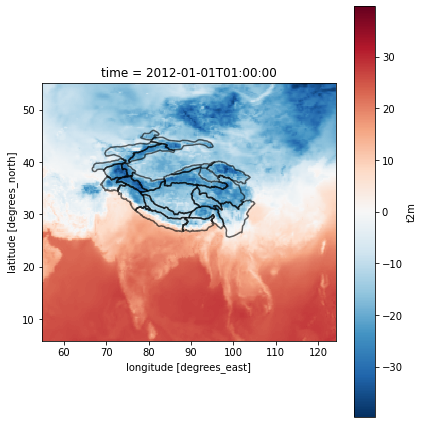

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
climate.t2m[1,:,:].plot()#palette='viridis')
hma.boundary.plot(ax=ax, alpha=.6, color='black')
fig.tight_layout()

In [315]:
''' change name of the mountain range here'''

roi = hma[hma['Name'] == hma_df.Name[8]]
name = roi.Name
print(roi.Name)
# karakoram.crs

8    Dzhungarsky Alatau
Name: Name, dtype: object


In [316]:
# add crs to the dataset (netcdf file) - maybe this is not even needed 
climate = climate.rio.write_crs('EPSG:4326')

# clip using xarrayrio library:
roi_climate = climate.rio.clip(roi.geometry, roi.crs, drop=True, invert=False)

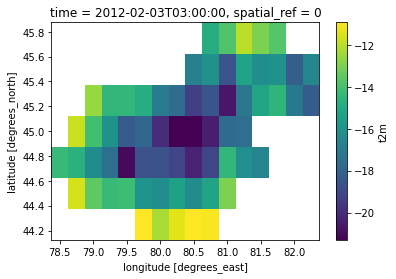

In [317]:
'''
# see how it looks like 
roi_climate.t2m[795,:,:].plot()
fig.tight_layout()
'''

In [318]:
'''
# calculate how many era5 pix fall into the mountain range polygon

x = roi_climate.t2m[1,:,:].values.flatten()
print('total numnber of pixels within bbox:', x.shape, '\n')

# without nans
x2 = x[~np.isnan(x)]
print('number of not-nan pixels:', x2.shape, '\n')


# check what to do for the median (in space) value: 
if (len(x2) % 2) == 0:
    print ('EVEN number of not-nans -> ceiling/floor median')
else:print ('ODD number of not-nans -> regular median is ok')
'''

total numnber of pixels within bbox: (112,) 

number of not-nan pixels: (66,) 

EVEN number of not-nans -> ceiling/floor median


### time dimention (-> value IN TIME)

In [319]:
## "flatten" the data over time: reduce to smth (median temperatures/sum of precipitation over the year/etc) 

# statistics + keep the coordinates -> value IN TIME 
roi_climate_median = roi_climate.median(dim='time', keep_attrs = True, skipna=True)
# roi_climate_sum    = roi_climate.sum(dim='time', keep_attrs = True)


### space dimention (with pandas)

In [320]:
# with pandas: 
# (1) compute median in time (-> on the previous step) 
# (2) convert to dataframe (with coords being index)
# (3) kick out nans and duplicates
# (4) compute median (or some other thing) across the table 
# (5) find the index of the value that eq=median


# to dataframe - median:
roi_climate_median_df = roi_climate_median.to_dataframe() # dimentions: number of catchments squared
roi_climate_median_df = roi_climate_median_df.dropna()
roi_climate_median_df = roi_climate_median_df.drop_duplicates()
# sanity check:
print('length of the df:', len(roi_climate_median_df))

# to dataframe - sum:
# roi_climate_sum_df = roi_climate_sum.to_dataframe() # dimentions: number of catchments squared
# roi_climate_sum_df = roi_climate_sum_df.dropna()
# roi_climate_sum_df = roi_climate_sum_df.drop_duplicates()


 
# roi_climate_median_df.head()

/Users/varyabazilova/opt/anaconda3/envs/project1/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


length of the df: 66


### median value of the not-nan pixels: 

In [321]:
# since there are even number of pixels calculate medians in space this way: 

def median_ceil(values):
    values = sorted(values)
    values_len = len(values)
    middle = values_len//2
    return values[middle]

# t2m: 
t2m_median = roi_climate_median_df[roi_climate_median_df.t2m==median_ceil(values=roi_climate_median_df.t2m)]
# tp_median = roi_climate_median_df[roi_climate_median_df.tp==median_ceil(values=roi_climate_median_df.tp)]

print('name of the mountain range:', roi.Name, '\n')

print('coordinates for the median temperature:', t2m_median.index, '\n') 


# print('coordinates for the median precipitation:', tp_median.index) # more then one 

name of the mountain range: 8    Dzhungarsky Alatau
Name: Name, dtype: object 

coordinates for the median temperature: MultiIndex([(44.75, 79.0)],
           names=['latitude', 'longitude']) 



In [322]:
# t2m_median.tp.values[0]
# t2m_median

,,spatial_ref,ssrd,t2m,tcc,tp
latitude,longitude,,,,,
44.75,79.0,0,10.947222,1.454086,0.372087,0.000004


In [303]:
# median temperature coordinates: 

# 0. Eastern Hindu Kush           35.25, 72.75  0.290222
# 1. Weatern Himalaya             32.0,  77.5   -4.169601
# 2. Eastern Himalaya             27.75, 91.0   5.055511
# 3. Central Himalaya             31.25, 78.0   5.66568
# 4. Karakoram                    34.5,  78.5   -13.504562
# 5. Western Pamir                37.25, 72.25  -9.19783
# 6. Pamir Alay                   39.0,  69.0   0.0010654
# 7. Northern/Western Tien Shan   43.0,  80.0   3.12915
# 8. Dzhungarsky Alatau           44.75, 79.0   1.454086
# 9. Western Kunlun Shan          36.25, 82.75
# 10. Nyainqentanglha             29.0,  97.0
# 11. Gangdise Mountains          31.75, 81.25
# 12. Hengduan Shan               30.5,  100.75
# 13. Tibetan Interior Mountains  32.75, 81.25
# 14. Tanggula Shan               33.75, 91.75
# 15.  Eastern Tibetan Mountains  34.0,  99.75
# 16. Qilian Shan                 37.5,  100.0
# 17. Eastern Kunlun Shan         35.75, 96.5
# 18. Altun Shan                  39.0,  90.25
# 19. Eastern Tien Shan           43.75, 92.0
# 20. Central Tien Shan           42.75, 83.75
# 21. Eastern Pamir               38.0,  75.5

In [304]:
len(median_t2m_regions)
np.random.rand(21, 1)

array([[0.20162865],
       [0.59924363],
       [0.70342161],
       [0.95421458],
       [0.06166486],
       [0.46230939],
       [0.65894946],
       [0.61674005],
       [0.04103727],
       [0.70268915],
       [0.61719815],
       [0.53704569],
       [0.30056237],
       [0.0134651 ],
       [0.30903605],
       [0.29790367],
       [0.44146246],
       [0.2318063 ],
       [0.69007683],
       [0.42959151],
       [0.94468616]])

In [267]:
median_t2m_regions = {'Name': ['Eastern Hindu Kush',
                               'Weatern Himalaya','Eastern Himalaya',
                               'Central Himalaya','Karakoram', 'Western Pamir','Pamir Alay', 
                               'Northern/Western Tien Shan','Dzhungarsky Alatau', 'Western Kunlun Shan', 
                               'Nyainqentanglha','Gangdise Mountains','Hengduan Shan','Tibetan Interior Mountains',
                               'Tanggula Shan','Eastern Tibetan Mountains', 'Qilian Shan', 'Eastern Kunlun Shan',
                               'Altun Shan', 'Eastern Tien Shan', 'Central Tien Shan','Eastern Pamir'], 
                      'latitude': [35.25, 32.0, 27.75, 31.25, 34.5, 37.25, 39.0, 43.0, 44.75, 36.25, 29.0, 31.75,
                                   30.5, 32.75, 33.75, 34.0, 37.5, 35.75, 39.0, 43.75, 42.75, 38.0], 
                      'longitude': [72.75, 77.5, 91.0, 78.0, 78.5, 72.25, 69.0, 80.0, 79.0, 82.75, 97.0, 81.25, 
                                    100.75, 81.25, 91.75, 99.75, 100.0, 96.5, 90.25, 92.0, 83.75, 75.5], 
                     't2m_median': [0.73659009, 0.19074378, 0.81064375, 0.02009691, 0.57620778, 0.74666311, 
                                     0.01623963, 0.63717112, 0.5501115 , 0.29064179, 0.40919325, 0.81662932,
                                     0.73138669, 0.09465212, 0.74668592, 0.73618097, 0.0066972 , 0.50072078, 
                                     0.26561449, 0.50966153, 0.96181533, 0.81064375]}




median_t2m_regions= pd.DataFrame(median_t2m_regions).set_index('Name')

In [268]:
median_t2m_regions.head() 

,latitude,longitude,t2m_median
Name,,,
Eastern Hindu Kush,35.25,72.75,0.736590
Weatern Himalaya,32.00,77.50,0.190744
Eastern Himalaya,27.75,91.00,0.810644
Central Himalaya,31.25,78.00,0.020097
Karakoram,34.50,78.50,0.576208


### plot points with the outlines pf the regions 

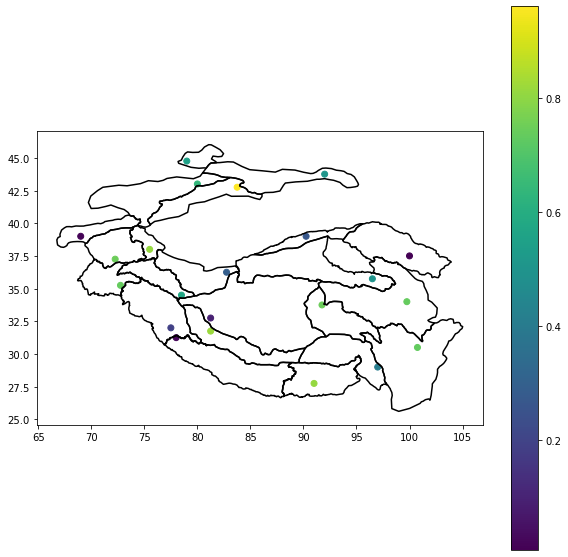

In [277]:
fig, ax = plt.subplots(figsize=(10, 10))
# hma bounds
hma.boundary.plot(ax = ax, color='black' )
# points
plt.scatter(x = median_t2m_regions.longitude, y = median_t2m_regions.latitude, c = median_t2m_regions.t2m_median)

plt.colorbar()


### get time-series for all these coordinates (temperature) 

In [47]:
# go to gee and find images for the may snow line (snow presistence) 
# Snow persistence is defined as the fraction of time that a grid cell is covered by snow. 


In [48]:
# roi_climate
# lon - 72
# lat - 37
# t2m_median['t2m'].iloc[0] - t2m_median 

### Get time-series of the temperature median

In [49]:
# select data 
ts = roi_climate.sel(longitude = 78.5, latitude = 34.5, method = 'nearest')
# convert to df
ts_df = ts.to_dataframe()

In [50]:
ts_df.head()

,latitude,longitude,spatial_ref,ssrd,t2m,tcc,tp
time,,,,,,,
2012-01-01 00:00:00,29.75,88.25,0,NaN,NaN,NaN,NaN
2012-01-01 01:00:00,29.75,88.25,0,NaN,NaN,NaN,NaN
2012-01-01 02:00:00,29.75,88.25,0,NaN,NaN,NaN,NaN
2012-01-01 03:00:00,29.75,88.25,0,NaN,NaN,NaN,NaN
2012-01-01 04:00:00,29.75,88.25,0,NaN,NaN,NaN,NaN


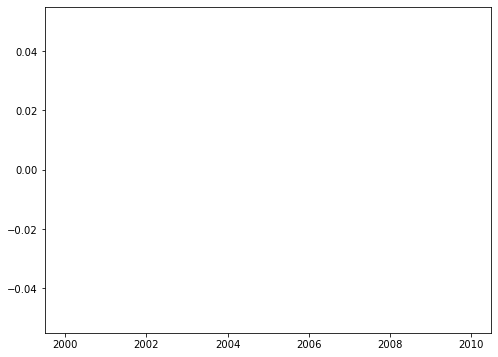

In [51]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.plot(ts_df.t2m)
ax.plot(ts_df.tp)
# ax2.plot(df.time, df.tcc, 'b-')ts_df.t2m.plot()

Text(0, 0.5, 'tp')

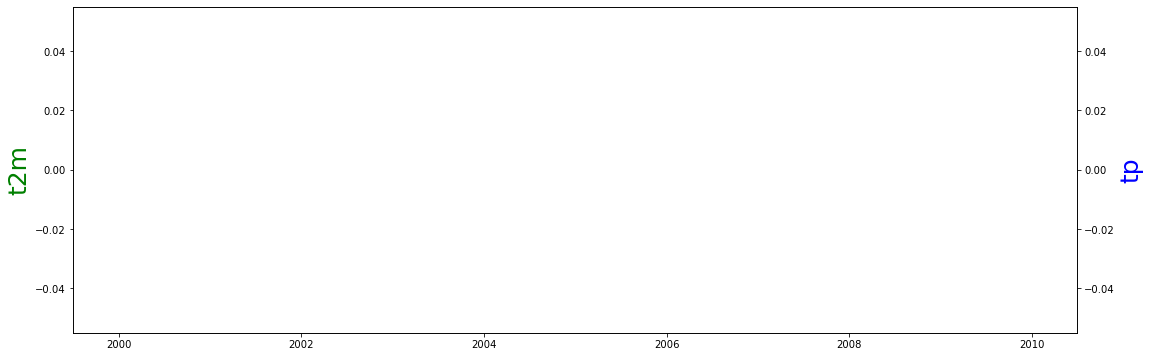

In [52]:
fig, ax1 = plt.subplots(figsize = (18,6))

ax2 = ax1.twinx()

ax1.plot(ts_df.t2m, 'g')
ax2.plot(ts_df.tp, 'b')

ax1.set_ylabel('t2m', color='g', fontsize = 25)
ax2.set_ylabel('tp', color='b', fontsize = 25)

### xr.where() - way
#### spatial dimention (-> value IN SPACE + find location ) 

In [22]:
# calculate the median value over the region -> vallue IN SPACE 
# then find it's location 
# https://docs.xarray.dev/en/latest/generated/xarray.DataArray.where.html

# roi_t2m_median = roi_climate_median.t2m.median()#dim = axes, keep_attrs = True)


In [23]:
# with numpy (for T2M and TP): 

# t2m median vallue:
# t2m_median['t2m'].iloc[0] - value from median table: 
median_t2m_where = roi_climate_median.t2m.where(roi_climate_median.t2m == t2m_median['t2m'].iloc[0])


/Users/varyabazilova/opt/anaconda3/envs/project1/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


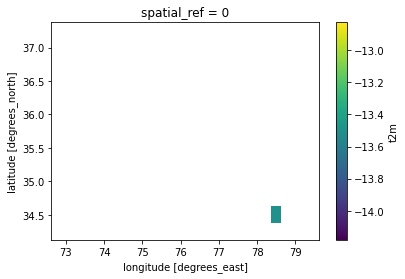

In [24]:
median_t2m_where.plot()

In [25]:
# type(roi_climate_median)
# type(median_t2m)
# ds
# t2m_median['t2m'].iloc[0] - t2m_median 

## annual sum of precipitation, then take median vallue of the precipitation sum

In [26]:
# read file:

annual_tp = xr.open_dataset('/Users/varyabazilova/Desktop/hma_regions/era5_resampled_to_annual/total_precipitation_annual_sum_1979to2020.nc', decode_coords="all")

In [27]:
# clip with roi of interest
# add crs to the dataset (netcdf file) - maybe this is not even needed 
annual_tp = annual_tp.rio.write_crs('EPSG:4326')

# clip using xarrayrio library:
roi_annual_tp = annual_tp.rio.clip(roi.geometry, roi.crs, drop=True, invert=False)


In [28]:
# calculate median vallue of in time

annual_median = roi_annual_tp.median(dim = 'year', keep_attrs = True)

In [29]:
## calculate not nan values 
count = roi_annual_tp.tp[1,:,:].values.flatten()
print('total numnber of pixels within bbox:', count.shape)

# without nans
count2 = count[~np.isnan(count)]
print('number of not-nan pixels:', count2.shape)



total numnber of pixels within bbox: (728,)
number of not-nan pixels: (264,)


In [30]:
# check for the median: 
if (len(count2) % 2) == 0:
    print ('EVEN number of not-nans -> ceiling/floor median')
else:print ('ODD number of not-nans -> regular median is ok')

EVEN number of not-nans -> ceiling/floor median


In [31]:
# convert to data frame 
# to dataframe - sum:
annual_median_df = annual_median.to_dataframe() # dimentions: number of catchments squared
annual_median_df = annual_median_df.dropna().drop_duplicates()
# roi_climate_sum_df = roi_climate_sum_df.drop_duplicates()


In [32]:
# annual_median_df.head()


In [33]:
# since there are even number of pixels calculate medians in space this way: 

# def median_ceil(values):
    # values = sorted(values)
    # values_len = len(values)
    # middle = values_len//2
    # return values[middle]

# t2m: 
annual_median_xy = annual_median_df[annual_median_df.tp==median_ceil(values=annual_median_df.tp)]

print('region of interest:\n', roi.Name, '\n')

print('coordinates for the median precipitation:\n', annual_median_xy.index) # more then one 



region of interest:
 4    Karakoram
Name: Name, dtype: object 

coordinates for the median precipitation:
 MultiIndex([(36.75, 73.0, 0)],
           names=['latitude', 'longitude', 'expver'])


In [48]:
annual_tp_where = annual_median.tp.where(annual_median.tp == annual_median_xy['tp'].iloc[0])

# annual_tp_where

In [49]:
annual_tp_where = annual_tp_where.drop('spatial_ref')


<xarray.DataArray 'tp' (latitude: 13, longitude: 28, expver: 2)>
array([[[       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
...
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 37.25 37.0 36.75 36.5 ... 34.75 34.5 34.25
  * longitude  (longitude) float64 72.75 73.0 73.25 73.5 ... 79.0 79.25 79.5
Dimensions without coordinates: expver

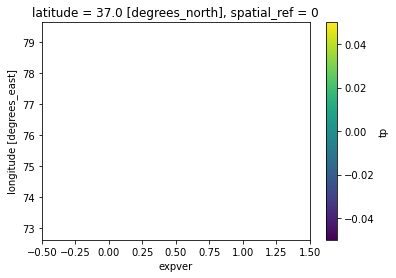

In [52]:
annual_tp_where[1,:,:].plot()



In [34]:
# resample things somehow? 

# resample for the YEAR resolution: 
# 1. precipitation: (1) take annual sum (2) ???

In [35]:
# to select mnt-range by name see this: 
# https://github.com/pydata/xarray/issues/501